The Dataset consists of a Train set and Test set with subfolders as normal and pneumonia. Pneumonia has the chest x-ray images of people who are suffering from pneumonia and the normal folder has images who are normal i.e free from lung disease.

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

Here, we will be resizing all the images to 224 * 224 because we use the VGG16 model and it accepts images of size 224 * 224

In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We will specify the train and test path for training.


In [4]:
train_path = '/content/drive/MyDrive/chest_xray/train'
valid_path = '/content/drive/MyDrive/chest_xray/test'

Importing VGG16

In [5]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


Here, we will import the VGG16 model weights for our application. We should declare an image size to the model, which we have done in the previous step, argument 3 represents that the image will accept RGB image i.e the color image. To train our model, we use imagenet weights and include_top = False means it will remove the last layers from the model.

VGG16 is the model designed in 2014 at ImageNet Large Scale Visual Recognition Challenge on Imagenet Dataset which has over 14 million images and this model can classify almost 1000 images.

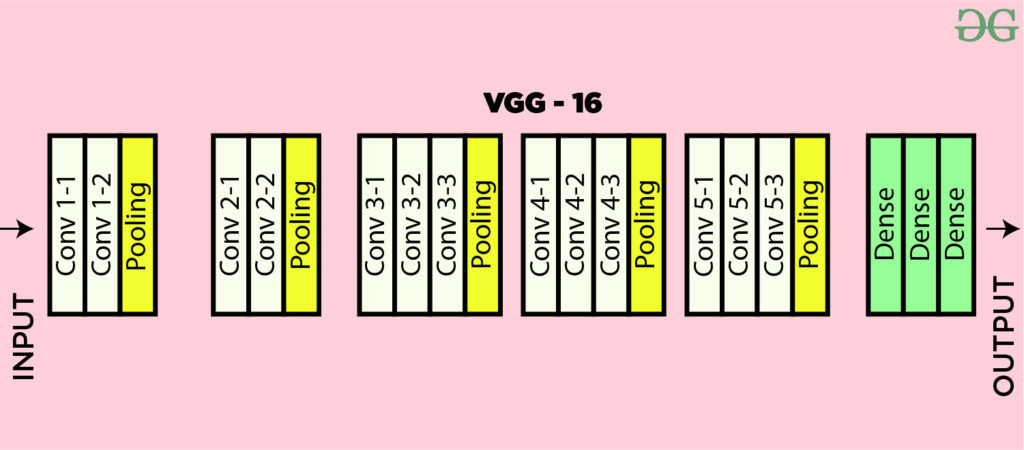

**Training Layers**


Models like VGG16, VGG19, Resnet, and others have been trained on thousands and thousands of images and these weights are used to classify thousands of classes so we use these models weights for classification of our model, so we do not need to train the model again.

In [6]:
for layer in vgg.layers:
  layer.trainable = False

Number of Classes

we use glob to find out the number of classes in our model. The number of subfolders in our train folder represents the number of classes in our model

In [7]:
folders = glob('/content/drive/MyDrive/chest_xray/train/*')

Flattening

Whatever we got as output from VGG16, we are going to flatten it and we removed the last layers from VGG16 so that we can keep our own output layer. we replace the last layer with the number of categories we have in our problem statement. We consider softmax as our activation function and we are appending it to x.

In [8]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

Model

We will wrap it into a model where the input refers to what we have from VGG16 and output refers to the output layer that we created in the previous step.

In [9]:
model = Model(inputs=vgg.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

summary of our model and in the dense layer, we have two nodes because of two different categories we have pneumonia and normal.



In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

We compile our model using categorical_cross_entropy as loss, adam optimizer, and accuracy as metrics. 

We will apply some transformations on the training images to avoid overfitting, if we do not perform we get a large difference between the accuracy of the training set and the test set.

We perform some geometrical transformations like flipping the image horizontally, flipping vertically, zoom in, zoom out and many more can be performed, we apply it so that our model won’t over learn our training images. We perform the above methods using the ImageDataGenerator class.

We don’t apply transformations for the test set because we only use them to evaluate, the only task to do with our test set is to rescale the images because in the training part we defined a target size for the image that could be fed into the network.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# rescaling converts images of range [0,255] to [0,1] to prevent the total loss and contribution can be done equally.

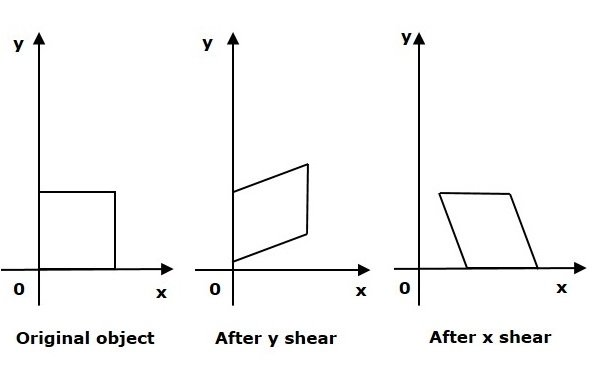

In [13]:
test_datagen = ImageDataGenerator(rescale = 1./255)

flow_from_directory will connect the Image Augmentation process to our training set. We need to mention the path of our training set. Target size is the size of the image that should be fed into the Neural Network. Batch size is defined as the no of images in a batch, the class mode would be categorical as we only have two outputs.

In [14]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


Now we define the test set that imports our test images from the directory. We do define the batch size, target size, and class mode as same mentioned in the training set.

In [15]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


We will fit our model and declare the number of epochs as five, steps per epoch would be the length of the training set and validation steps would be the length of the test set

In [16]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
163/163 [==============================] - 3988s 24s/step - loss: 0.2014 - accuracy: 0.9239 - val_loss: 0.4102 - val_accuracy: 0.8590
Epoch 2/5
163/163 [==============================] - 122s 749ms/step - loss: 0.1132 - accuracy: 0.9565 - val_loss: 0.2451 - val_accuracy: 0.9231
Epoch 3/5
163/163 [==============================] - 125s 768ms/step - loss: 0.1113 - accuracy: 0.9588 - val_loss: 0.4228 - val_accuracy: 0.8798
Epoch 4/5
163/163 [==============================] - 115s 705ms/step - loss: 0.0776 - accuracy: 0.9707 - val_loss: 0.3056 - val_accuracy: 0.9183
Epoch 5/5
163/163 [==============================] - 116s 712ms/step - loss: 0.0792 - accuracy: 0.9712 - val_loss: 0.3385 - val_accuracy: 0.9087


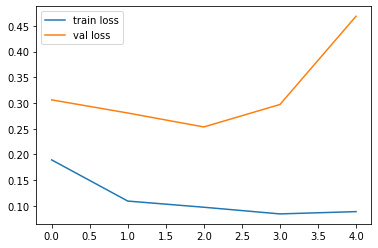

<Figure size 432x288 with 0 Axes>

In [19]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')